The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install ..  # installing d2l


# 机器翻译和数据集
:label:`sec_machine_translation`

我们使用 RNN 来设计语言模型，这是自然语言处理的关键。另一个旗舰基准是 * 机器转换 *，这是将输入序列转换为输出序列的 * 序列传感 * 模型的核心问题领域。序列转导模型在各种现代 AI 应用中发挥关键作用，将成为本章剩余部分和 :numref:`chap_attention` 的重点。为此，本节介绍机器翻译问题及其稍后将使用的数据集。

*机器翻译 * 是指
将序列从一种语言自动翻译为另一种语言。事实上，这个领域可能追溯到 20 世纪 40 年代数字计算机发明之后不久，特别是考虑在二战中使用计算机破解语言代码。几十年来，在使用神经网络进行端到端学习兴起之前，统计方法在该领域占主导地位 :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990`。后者通常被称为
*神经机器翻译 *
将自己与
*统计机翻译 *
这涉及对翻译模型和语言模型等组成部分进行统计分析.

本书强调端到端学习，将重点介绍神经机器翻译方法。与我们在 :numref:`sec_language_model` 语料库中使用单一语言的语料模型问题不同，机器翻译数据集由分别使用源语言和目标语言的文本序列对组成。因此，我们需要一种不同的方法来预处理机器翻译数据集，而不是重复使用预处理程序进行语言建模。在下面，我们将展示如何将预处理的数据加载到小批中进行培训。


In [1]:
import os
import torch
from d2l import torch as d2l

## 下载和预处理数据集

首先，我们下载一个由 [bilingual sentence pairs from the Tatoeba Project](http://www.manythings.org/anki/) 组成的英法数据集。数据集中的每一行都是一对制表符分隔的英文文本序列和翻译的法语文本序列。请注意，每个文本序列可以只是一个句子，也可以是多个句子的一段。在这个英语翻译成法语的机器翻译问题中，英语是 * 源语言 *，法语是 * 目标语言 *。


In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



下载数据集后，我们将继续对原始文本数据进行几个预处理步骤。例如，我们用空格替换不间断的空格，将大写字母转换为小写字母，然后在单词和标点符号之间插入空格。


In [3]:
#@save
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## 令牌化

与 :numref:`sec_language_model` 中的字符级令牌化不同，对于机器翻译，我们更喜欢这里的字级标记化（最先进的模型可能使用更先进的标记化技术）。以下 `tokenize_nmt` 函数标记了前 `num_examples` 文本序列对，其中每个标记都是一个单词或标点符号。此函数返回两个令牌列表：`source` 和 `target`。具体来说，`source[i]` 是源语言（英语）$i^\mathrm{th}$ 文本序列中的令牌列表，`target[i]` 是目标语言（此处法语）。


In [4]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

让我们绘制每个文本序列的令牌数的直方图。在这个简单的英法数据集中，大多数文本序列的令牌少于 20 个。


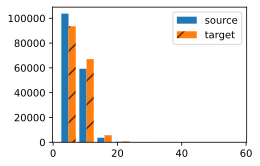

In [5]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l)
                               for l in source], [len(l) for l in target]],
                             label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

## 词汇

由于机器翻译数据集由对语言组成，因此我们可以为源语言和目标语言分别构建两个词汇表。使用单词级令牌化，词汇量大小将远远大于使用字符级标记的词汇量。为了缓解这种情况，这里我们将出现少于 2 倍的不经常的令牌视为同一个未知 (” <unk> “) 令牌。除此之外，我们还指定了额外的特殊标记，例如用于填充 (” <pad> “) 序列的小批次长度相同，以及用于标记 <bos> <eos> 序列的开头 (” “) 或 end (” “)。这种特殊令牌通常用于自然语言处理任务。


In [6]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## 加载数据集
:label:`subsec_mt_data_loading`

回想一下，在语言建模中，每个序列示例，无论是一个句子的一段或多个句子的跨度，都有固定的长度。:numref:`sec_language_model` 中的 `num_steps`（时间步长或令牌数）参数指定了这一点。在机器翻译中，每个示例都是一对源文本序列和目标文本序列，其中每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过 * 截断 * 和 * 填充 * 同时处理一批文本序列。假设同一个小批次中的每个序列都应该具有相同的长度 `num_steps`。如果文本序列的令牌少于 `num_steps`，我们将继续将特殊的 “<pad>” 令牌附加到其末尾，直到其长度达到 `num_steps`。否则，我们将通过仅获取第一个 `num_steps` 令牌并丢弃剩余的来截断文本序列。通过这种方式，每个文本序列的长度将相同，以相同形状的小批量加载。

如前所述，以下 `truncate_pad` 函数会截断或填充文本序列。


In [7]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义了一个函数来将文本序列转换为小批进行训练。我们将特殊的 “<eos>” 标记附加到每个序列的末尾，以表示序列的结束。当模型通过在令牌后生成序列令牌来进行预测时，“<eos>” 令牌的生成可能表明输出序列已完成。此外，我们还记录每个文本序列的长度，不包括填充标记。我们稍后将介绍的一些模型将需要这些信息。


In [8]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

## 把所有东西放在一起

最后，我们定义了 `load_data_nmt` 函数来返回数据迭代器，以及源语言和目标语言的词汇表。


In [9]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

让我们阅读英法数据集中的第一个小批。


In [10]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[132, 113,   0,   4,   3,   1,   1,   1],
        [ 37,  10,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for X: tensor([5, 4])
Y: tensor([[86, 93, 77,  0,  5,  3,  1,  1],
        [96,  8,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for Y: tensor([6, 4])


## 摘要

* 机器翻译是指将序列从一种语言自动翻译为另一种语言。
* 使用单词级令牌化，词汇量大小将明显大于使用字符级令牌化的词汇量。为了缓解这种情况，我们可以将不常见的令牌视为同一个未知代币。
* 我们可以截断和填充文本序列，以便所有文本序列都具有相同的长度以小批量加载。

## 练习

1. 在 `load_data_nmt` 函数中尝试 `num_examples` 参数的不同值。这对源语言和目标语言的词汇量大小有何影响？
1. 某些语言（如中文和日语）的文本没有字边界指示符（例如空格）。对于这种情况，单词级标记化仍然是一个好主意吗？为什么或为什么不？


[Discussions](https://discuss.d2l.ai/t/1060)
